In [6]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
test_x = pd.read_csv('test.csv')

validate = train.iloc[32000:,:]
train = train.iloc[:32000,:]

In [2]:
import tensorflow as tf


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers

from kerastuner.engine.hyperparameters import HyperParameters


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [3]:
train_x = train.drop(columns=['label'])
train_y = pd.DataFrame(train['label'])

validate_x = validate.drop(columns=['label'])
validate_y = pd.DataFrame(validate['label'])

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [4]:
classes = [0,1,2,3,4,5,6,7,8,9]

classes = pd.DataFrame(
    data={
        'label': classes
    }
)

classes.index.name = 'class_id'
classes

,label
class_id,
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8


In [7]:
shape_trx = train_x.shape
shape_try = train_y.shape
shape_vx = validate_x.shape
shape_vy = validate_y.shape
shape_tex = test_x.shape
print("Training Set Shapes")

print(shape_trx)
print(shape_try)
print("\nValidation Set Shapes")

print(shape_vx)
print(shape_vy)
print("\nTest Set Shape")

print(shape_tex)


Training Set Shapes
(32000, 784)
(32000, 1)

Validation Set Shapes
(10000, 784)
(10000, 1)

Test Set Shape
(28000, 784)


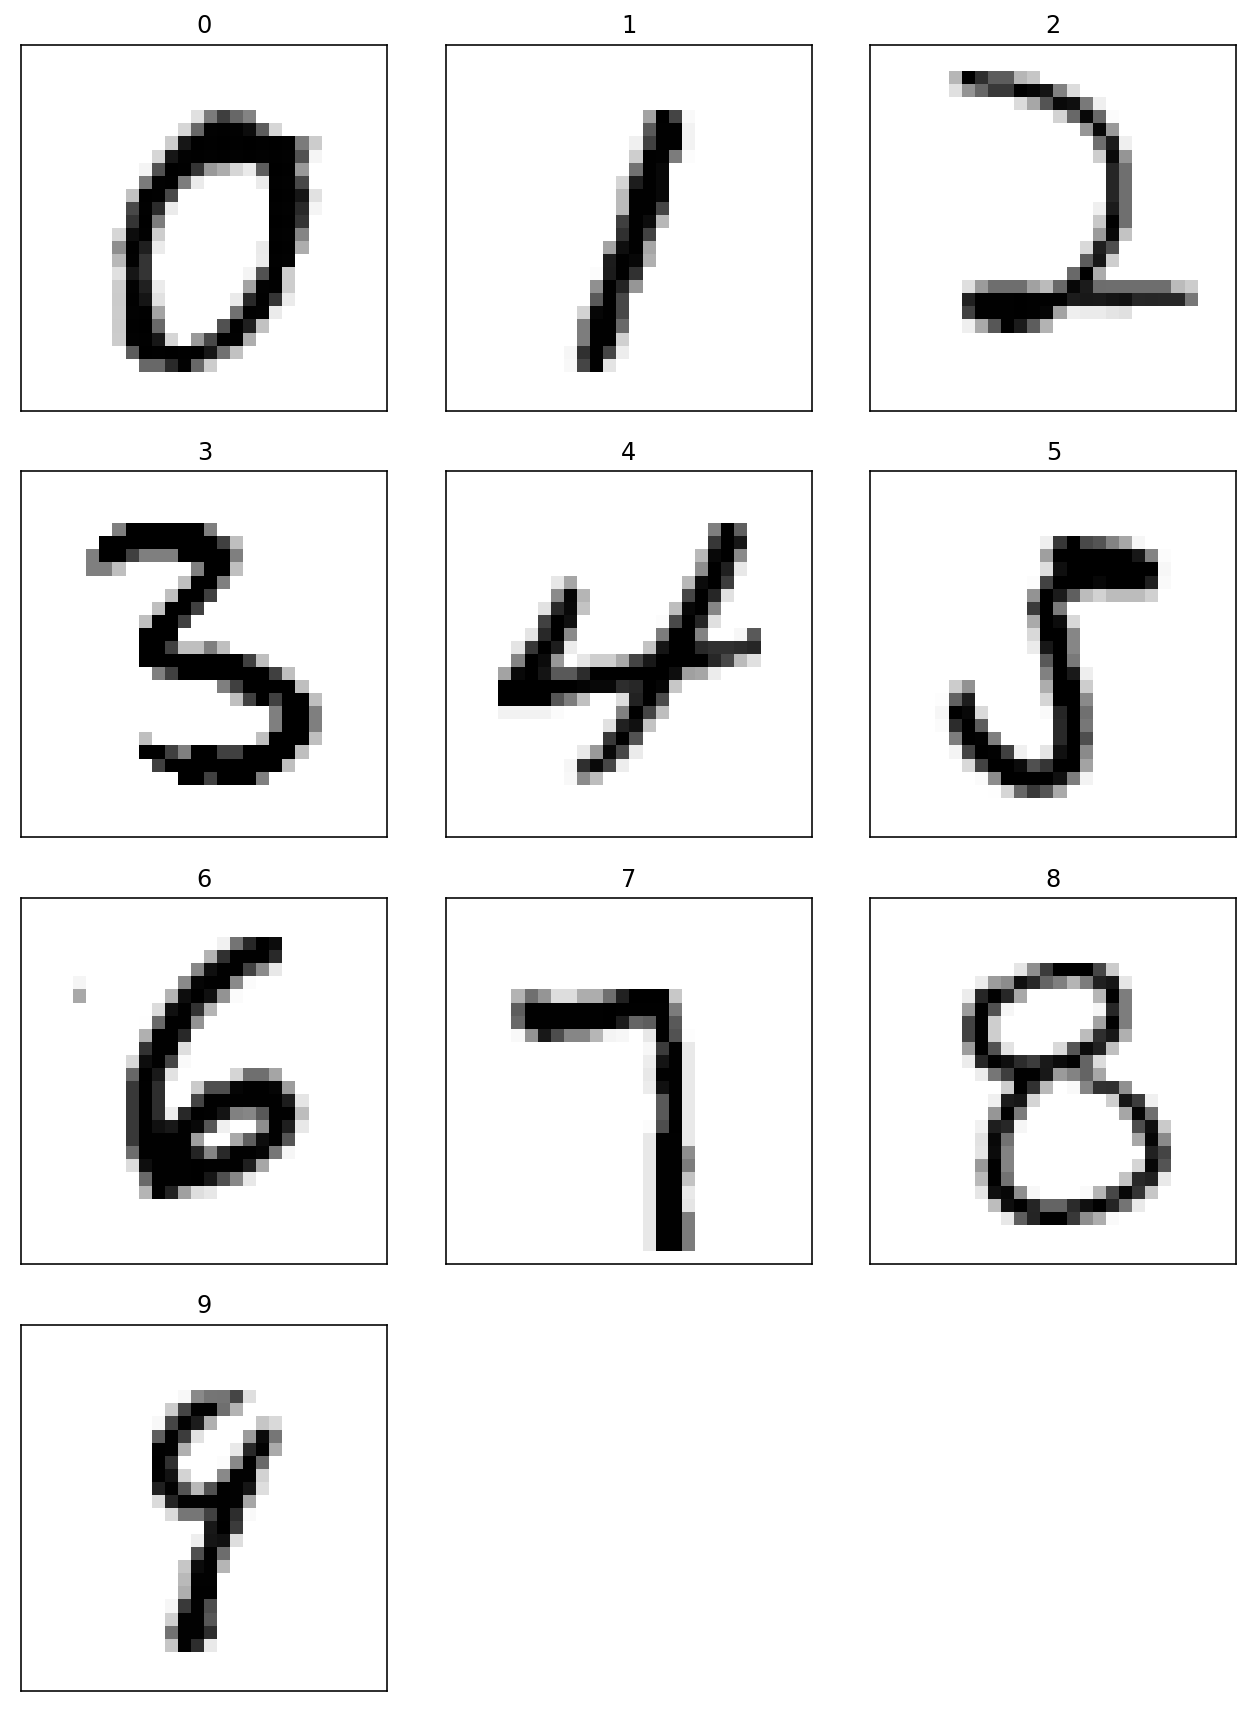

In [8]:
import math


n = classes.shape[0]
ncols = 3
nrows = math.ceil(n/ncols)

plt.figure(figsize=[3*ncols, 3*nrows])
for idx, cl in classes['label'].iteritems():
    plt.subplot(nrows, ncols, idx+1)
    
    img = train_x.loc[train_y['label'] == idx].sample(1)
    img = img.values.reshape(28, 28)
    plt.imshow(img, cmap='binary')
    
    plt.title(classes.loc[idx, 'label'])
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.show()

In [9]:
from sklearn.preprocessing import OneHotEncoder

class_encoder = OneHotEncoder(categories="auto")
class_encoder.fit(train_y)

OneHotEncoder()

In [10]:
train_y_1h = class_encoder.transform(train_y).toarray()
validate_y_1h = class_encoder.transform(validate_y).toarray()

train_x_scale = (train_x.astype('float')/255).values
test_x_scale = (test_x.astype('float')/255).values
validate_x_scale = (validate_x.astype('float')/255).values

In [13]:
train_x_re = train_x_scale.reshape(32000,28,28,1)
validate_x_re = validate_x_scale.reshape(10000,28,28,1)
test_x_re = test_x_scale.reshape(28000,28,28,1)

In [14]:
def build_model(hp: HyperParameters):
    
    # Adding hyperparameters
    
    model = Sequential()

    convol_1 = hp.Int(name = 'convolutional layer 1', min_value=20, max_value=120, step=20) 
    convol_2 = hp.Int(name = 'convolutional layer 2', min_value=10, max_value=60, step=10) 
    
    kernel_size = hp.Int(name = 'kernel_size', min_value=1, max_value=4, step=1)

    dense_units = hp.Int(name = 'dense units', min_value=40, max_value=160, step=20) 
    dense_act = hp.Choice(name = 'dense activation', values = ['relu','sigmoid'])

    dropout = hp.Float(name = 'dropout', min_value=0.05, max_value=0.4, step=0.05)

    opt_lr = hp.Float(name='learning_rate', min_value=1e-3, max_value=5e-3, step=5e-4)
    
    max_pooling = hp.Int(name = 'max pooling', min_value=2, max_value=3, step=1)

    
    # Creating layers
    
    model.add(Conv2D(convol_1, kernel_size=(kernel_size,kernel_size), input_shape=(28,28,1))),
        
    model.add(MaxPooling2D(pool_size=(max_pooling, max_pooling))),

    model.add(Conv2D(convol_2, kernel_size=(kernel_size,kernel_size), input_shape=((28 + 1 - kernel_size) + 1 - max_pooling,
                    (28 + 1 - kernel_size) + 1 - max_pooling, convol_1))),
        
    model.add(MaxPooling2D(pool_size=(max_pooling, max_pooling))),

    model.add(Flatten()),
        
    model.add(Dense(units=dense_units, activation=dense_act)),        
        
    model.add(Dropout(dropout)),
    

    model.add(Dense(units = 10,activation='softmax'))
    
    # Compile model
  
    model.compile(optimizers.Adam(lr=opt_lr), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [15]:
def train_model(model, epochs):
    history = model.fit(
        x=train_x_re, 
        y=train_y_1h, 

        epochs=epochs,

        batch_size=128,
        shuffle=True,
        validation_data=(validate_x_re, validate_y_1h)
    )
    return history

In [16]:
from kerastuner.tuners import RandomSearch


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='clothing_estimator',
    
    # Experiment name must change if you modify
    # the model structure or the set of hyperparameters.
    project_name='clothing_estimator_'
)

# This displays which hyperparameters are tunable, and their respective distribution.
tuner.search_space_summary()

Search space summary
Default search space size: 8
convolutional layer 1 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 120, 'step': 20, 'sampling': None}
convolutional layer 2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 10, 'sampling': None}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
dense units (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 160, 'step': 20, 'sampling': None}
dense activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
dropout (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.4, 'step': 0.05, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.005, 'step': 0.0005, 'sampling': None}
max pooling (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step'

In [17]:
np.random.seed(3)
tf.random.set_seed(3)

tuner.search(    
    # All parameters here are passed thru to Model.fit function.
    x=train_x_re, 
    y=train_y_1h, 
    validation_data=(validate_x_re, validate_y_1h),
    
    # It's a good idea to have low number of epochs,
    # to test the learning process, but not for the final model training.
    epochs=5,
    batch_size=250,
    shuffle=True

)

Trial 5 Complete [00h 02m 09s]
val_accuracy: 0.9664500057697296

Best val_accuracy So Far: 0.9831999838352203
Total elapsed time: 00h 17m 32s
INFO:tensorflow:Oracle triggered exit


In [18]:
pd.DataFrame([
    {
        'trial_id': t.trial_id,
        'score': t.score,
        **t.hyperparameters.values 
    }
    for t in tuner.oracle.get_best_trials(num_trials=5)
]).set_index('trial_id')

,score,convolutional layer 1,convolutional layer 2,kernel_size,dense units,dense activation,dropout,learning_rate,max pooling
trial_id,,,,,,,,,
290171e28ef3d13823c4d40978f3f364,0.98320,80,60,2,100,sigmoid,0.15,0.0025,2
f92454707feb4828c5b4f1bc60bfb2fe,0.97335,100,20,4,40,relu,0.15,0.0050,3
3961e0d29f95f8f246e7e449996a02f4,0.97060,100,40,2,120,relu,0.15,0.0020,3
322a483b379c64795543b01962c2dff7,0.96645,60,10,3,100,sigmoid,0.05,0.0020,3
46c3f711b76529e6ff07460cf9c7bb78,0.90630,100,50,1,40,sigmoid,0.10,0.0015,2


In [19]:
classifier = tuner.get_best_models(num_models=1)[0]

In [20]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_hyperparameters.values

classifier = build_model(best_hyperparameters)
train_model(classifier, epochs=100)

Epoch 1/100
250/250 [==============================] - 26s 104ms/step - loss: 0.3461 - accuracy: 0.8997 - val_loss: 0.1092 - val_accuracy: 0.9701
Epoch 2/100
250/250 [==============================] - 25s 100ms/step - loss: 0.0987 - accuracy: 0.9726 - val_loss: 0.0703 - val_accuracy: 0.9788
Epoch 3/100
250/250 [==============================] - 24s 98ms/step - loss: 0.0682 - accuracy: 0.9810 - val_loss: 0.0503 - val_accuracy: 0.9844
Epoch 4/100
250/250 [==============================] - 25s 102ms/step - loss: 0.0472 - accuracy: 0.9867 - val_loss: 0.0508 - val_accuracy: 0.9845
Epoch 5/100
250/250 [==============================] - 26s 103ms/step - loss: 0.0379 - accuracy: 0.9890 - val_loss: 0.0459 - val_accuracy: 0.9850
Epoch 6/100
250/250 [==============================] - 24s 98ms/step - loss: 0.0303 - accuracy: 0.9916 - val_loss: 0.0482 - val_accuracy: 0.9853
Epoch 7/100
250/250 [==============================] - 25s 102ms/step - loss: 0.0275 - accuracy: 0.9921 - val_loss: 0.0467 - v

In [31]:
test_y_pred = classifier.predict(test_x_re)
test_y_pred_binary = class_encoder.transform(np.argmax(test_y_pred,1).reshape(-1,1)).toarray()
test_y_pred_binary

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [29]:
test_y_pred_binary = pd.DataFrame(test_y_pred_binary)
test_y_pred_binary_label = test_y_pred_binary.idxmax(axis=1)

In [51]:
df = pd.DataFrame(test_y_pred_binary_label).reset_index()
df.rename(columns={'index':'ImageId', 0:'Label'}, inplace=True)

df['ImageId'] = df['ImageId']+1

In [53]:
df.to_csv('numbers.txt', header=True, index=None, sep=',')